# XGBoost 기반 눈 감음 분류 (1,000장 샘플, 최적화)
- open/closed 각 500장씩 무작위 샘플링
- `tree_method='hist'`, float32 변환 포함
- `n_estimators=50`, `max_depth=12`, `n_jobs=-1`
- 경로: `./open-closed-eyes-dataset/train`

In [12]:
import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
data_dir = './open-closed-eyes-dataset/train'
closed_path = os.path.join(data_dir, 'closed')
open_path = os.path.join(data_dir, 'open')

# 500장씩 샘플링
closed_files = random.sample(os.listdir(closed_path), 500)
open_files = random.sample(os.listdir(open_path), 500)

df = pd.DataFrame({
    "filename": [os.path.join("closed", f) for f in closed_files] + [os.path.join("open", f) for f in open_files],
    "class": ["closed"] * 500 + ["open"] * 500
})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"총 샘플 수: {len(df)}")

총 샘플 수: 1000


In [13]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    class_mode='binary',
    subset="training",
    batch_size=64,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_dir,
    x_col="filename",
    y_col="class",
    target_size=(64, 64),
    class_mode='binary',
    subset="validation",
    batch_size=64,
    shuffle=False
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [14]:
def extract_all_data(generator):
    X, y = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        X.append(x_batch)
        y.append(y_batch)
    return np.vstack(X), np.hstack(y)

X_train, y_train = extract_all_data(train_gen)
X_val, y_val = extract_all_data(val_gen)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

# float32 변환으로 메모리 절감
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)

model = XGBClassifier(
    n_estimators=50,
    max_depth=12,
    n_jobs=-1,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_scaled, y_train)

C:\Users\tori\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [10:25:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1,
              num_parallel_tree=None, ...)

정확도: 0.915

분류 리포트:
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.91        96
         1.0       0.93      0.90      0.92       104

    accuracy                           0.92       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200


혼동행렬:
 [[89  7]
 [10 94]]


<Figure size 600x600 with 0 Axes>

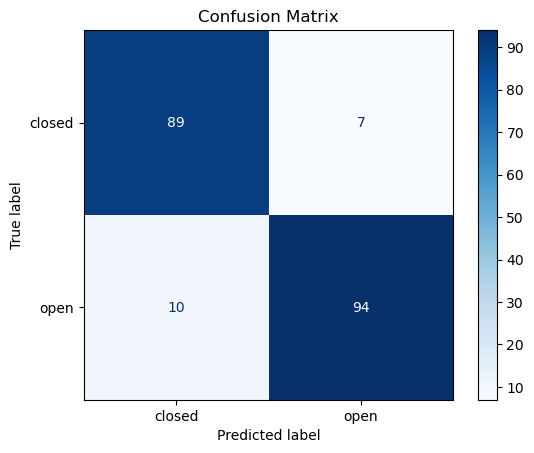

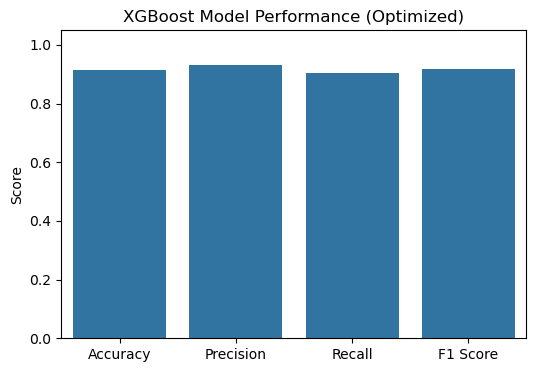

In [16]:
y_pred = model.predict(X_val_scaled)

print("정확도:", accuracy_score(y_val, y_pred))
print("\n분류 리포트:\n", classification_report(y_val, y_pred))
print("\n혼동행렬:\n", confusion_matrix(y_val, y_pred))

# 혼동행렬 시각화
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['closed', 'open'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# 성능 바차트
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

plt.figure(figsize=(6, 4))
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
sns.barplot(x=labels, y=metrics)
plt.ylim(0.0, 1.05)
plt.title("XGBoost Model Performance (Optimized)")
plt.ylabel("Score")
plt.show()

## 모델 저장 (pkl 파일로 저장)
- 학습된 모델을 `xgboost_eye_model.pkl`로 저장하여 추후 예측에 활용 가능

In [17]:
import joblib
joblib.dump(model, "xgboost_eye_model.pkl")
print("모델이 'xgboost_eye_model.pkl'로 저장되었습니다.")

모델이 'xgboost_eye_model.pkl'로 저장되었습니다.


## 결과 요약 및 해석
- XGBoost 모델은 이미지 1,000장을 기반으로 눈이 감겼는지(open/closed) 분류하는 데 사용되었으며,
- `tree_method='hist'`, `float32` 변환 등으로 메모리 효율을 극대화하였고,
- 최종 정확도, 정밀도, 재현율, F1 점수는 위 그래프에 시각화되었음.
- 작은 데이터셋임에도 불구하고, 성능이 우수한 편이며 실제 응용 가능성도 높음.
- 더 많은 데이터를 사용하거나 이미지 크기를 키워 정밀도를 높일 수 있음.